# DX 704 Week 1 Project

This week's project will build a portfolio risk and return model, and make investing recommendations for hypothetical clients.
You will collect historical data, estimate returns and risks, construct efficient frontier portfolios, and sanity check the certainty of the maximum return portfolio.

The full project description and a template notebook are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-01


Feel free to use optimization tools or libraries (such as CVXOPT or scipy.optimize) to perform any calculations required for this mini project.

### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Collect Data

Collect historical monthly price data for the last 24 months covering 6 different stocks.
The data should cover 24 consecutive months including the last month that ended before this week's material was released on Blackboard.
To be clear, if a month ends between the Blackboard release and submitting your project, you do not need to add that month.

The six different stocks must include AAPL, SPY and TSLA.
At least one of the remaining 3 tickers must start with the same letter as your last name (e.g. professor Considine could use COIN).
This is to encourage diversity in what stocks you analyze; if you discuss this project with classmates, please make sure that you pick different tickers to differentiate your work.
Do not pick stocks with fewer than 24 consecutive months of price data.

In [1]:
# Load libraries
import pandas as pd
import yfinance as yf
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Turn off scientific notation for pandas and numpy
pd.options.display.float_format = "{:.6f}".format
np.set_printoptions(suppress=True, formatter={"float_kind": "{:.6f}".format})

In [2]:
# YOUR CHANGES HERE
# Specify stocks
tickers = ["AAPL", "SPY", "TSLA", "PEP", "PYPL", "PARA"]

# Specify monthd
start_month = "2023-09-01"  
end_month_exclusive = "2025-09-01" 
target_months = pd.period_range("2023-09", "2025-08", freq="M")  


In [3]:
# Let's dowload daily data 
raw = yf.download(
    tickers=tickers,
    start=start_month,
    end=end_month_exclusive,
    auto_adjust=False,            
    progress=False,
    group_by="column",           
)

In [4]:
# Take a look
raw.head()

Price       Adj Close                                                       \
Ticker           AAPL      PARA        PEP      PYPL        SPY       TSLA   
Date                                                                         
2023-09-01 187.622269 13.195584 163.701614 63.570000 439.492126 245.009995   
2023-09-05 187.859909 13.195584 162.618484 63.740002 437.592712 256.489990   
2023-09-06 181.135788 12.953906 163.150711 62.799999 434.651031 251.919998   
2023-09-07 175.837677 12.586557 164.710037 61.650002 433.316528 251.490005   
2023-09-08 176.451660 13.205251 164.588654 60.980000 433.969116 248.500000   

Price           Close                                 ...       Open  \
Ticker           AAPL      PARA        PEP      PYPL  ...        PEP   
Date                                                  ...              
2023-09-01 189.460007 13.650000 175.320007 63.570000  ... 178.729996   
2023-09-05 189.699997 13.650000 174.160004 63.740002  ... 175.270004   
2023-09-06 182.910004 13.400000 174.729996 62.799999  ... 174.919998   
2023-09-07 177.559998 13.020000 176.399994 61.650002  ... 175.850006   
2023-09-08 178.179993 13.660000 176.270004 60.980000  ... 175.809998   

Price                                          Volume                     \
Ticker          PYPL        SPY       TSLA       AAPL      PARA      PEP   
Date                                                                       
2023-09-01 63.130001 453.170013 257.260010   45766500  32745292  4801400   
2023-09-05 63.380001 450.730011 245.000000   45280000  12582628  5081800   
2023-09-06 63.119999 448.399994 255.139999   81755800  15497299  5933800   
2023-09-07 62.000000 443.109985 245.070007  112488800  20686648  4934300   
2023-09-08 61.580002 444.899994 251.220001   65551300  13785068  2995000   

Price                                      
Ticker          PYPL       SPY       TSLA  
Date                                       
2023-09-01  11715200  58944100  132541600  
2023-09-05  12739100  55166200  129469600  
2023-09-06  13621300  70758500  116959800  
2023-09-07  12712700  70355400  115312900  
2023-09-08  15367400  61659700  118367700  

[5 rows x 36 columns]

In [5]:
raw.shape

(500, 36)

In [6]:
# Take only the adjusted price 
adj_close = raw["Adj Close"]


In [7]:
adj_close.head()

Ticker,AAPL,PARA,PEP,PYPL,SPY,TSLA
Date,,,,,,
2023-09-01,187.622269,13.195584,163.701614,63.570000,439.492126,245.009995
2023-09-05,187.859909,13.195584,162.618484,63.740002,437.592712,256.489990
2023-09-06,181.135788,12.953906,163.150711,62.799999,434.651031,251.919998
2023-09-07,175.837677,12.586557,164.710037,61.650002,433.316528,251.490005
2023-09-08,176.451660,13.205251,164.588654,60.980000,433.969116,248.500000


In [8]:
adj_close.shape

(500, 6)

In [9]:
# Resample to month-end prices (last trading day each month)
monthly_prices = adj_close.resample("ME").last()

In [10]:
monthly_prices.head()

Ticker,AAPL,PARA,PEP,PYPL,SPY,TSLA
Date,,,,,,
2023-09-30,169.549301,12.517362,158.211288,58.459999,417.865601,250.220001
2023-10-31,169.113556,10.557280,152.459503,51.799999,408.794373,200.839996
2023-11-30,188.355316,13.943760,158.335693,57.610001,446.135193,240.080002
2023-12-31,190.913666,14.397066,159.794006,61.410000,466.503693,248.479996
2024-01-31,182.851913,14.202381,158.561523,61.349998,473.933380,187.289993


In [11]:
monthly_prices.shape

(24, 6)

In [12]:
# Check if all have 24 months of data
print(monthly_prices.isna().any())

Ticker
AAPL    False
PARA    False
PEP     False
PYPL    False
SPY     False
TSLA    False
dtype: bool


In [13]:
monthly_prices.head()

Ticker,AAPL,PARA,PEP,PYPL,SPY,TSLA
Date,,,,,,
2023-09-30,169.549301,12.517362,158.211288,58.459999,417.865601,250.220001
2023-10-31,169.113556,10.557280,152.459503,51.799999,408.794373,200.839996
2023-11-30,188.355316,13.943760,158.335693,57.610001,446.135193,240.080002
2023-12-31,190.913666,14.397066,159.794006,61.410000,466.503693,248.479996
2024-01-31,182.851913,14.202381,158.561523,61.349998,473.933380,187.289993


Save the data as a TSV file named "historical_prices.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols. The date should be the last trading day of the month, so it may not be the last day of the month. For example, the last trading day of November 2024 was 2024-11-29. The remaining columns should contain the adjusted closing prices of the corresponding stock tickers on that day.


In [14]:
# YOUR CHANGES HERE

# Fix index
# Reset index so date is a column
monthly_prices = monthly_prices.reset_index()
monthly_prices.rename(columns={"Date": "date"}, inplace=True)

# Remove the column index name ("Ticker")
monthly_prices.columns.name = None

# Save to TSV, keeping 'date' as a regular column
monthly_prices.to_csv("historical_prices.tsv", sep="\t", index=False, float_format="%.6f")


In [15]:
monthly_prices.head()

,date,AAPL,PARA,PEP,PYPL,SPY,TSLA
0,2023-09-30,169.549301,12.517362,158.211288,58.459999,417.865601,250.220001
1,2023-10-31,169.113556,10.557280,152.459503,51.799999,408.794373,200.839996
2,2023-11-30,188.355316,13.943760,158.335693,57.610001,446.135193,240.080002
3,2023-12-31,190.913666,14.397066,159.794006,61.410000,466.503693,248.479996
4,2024-01-31,182.851913,14.202381,158.561523,61.349998,473.933380,187.289993


Submit "historical_prices.tsv" in Gradescope.

## Part 2: Calculate Historical Asset Returns

Calculate the historical asset returns based on the price data that you previously collected.

In [16]:
historical_prices = None

for t in tickers:
    ticker = yf.Ticker(t)
    history =  ticker.history(period="2y")

    monthly_prices = history['Close'].resample('ME').last()

    if historical_prices is None:
        historical_prices = monthly_prices
    else:
        historical_prices = pd.concat([historical_prices, monthly_prices], axis=1)

historical_prices.columns = tickers
historical_prices.index = pd.to_datetime(historical_prices.index).strftime("%Y-%m")

historical_prices

,AAPL,SPY,TSLA,PEP,PYPL,PARA
Date,,,,,,
2023-09,169.549286,417.865662,250.220001,158.211288,58.459999,12.517363
2023-10,169.113541,408.794403,200.839996,152.459503,51.799999,10.557281
2023-11,188.355316,446.135193,240.080002,158.335693,57.610001,13.943761
2023-12,190.913666,466.503662,248.479996,159.794037,61.410000,14.397066
2024-01,182.851898,473.933441,187.289993,158.561508,61.349998,14.202380
2024-02,179.461273,498.666504,201.880005,156.747299,60.340000,10.746694
2024-03,170.257339,514.973877,175.789993,165.914749,66.989998,11.506557
2024-04,169.115555,494.210358,183.279999,166.767990,67.919998,11.135063
2024-05,191.138168,519.207336,178.080002,163.914413,62.990002,11.643424


In [17]:
# Save to TSV, keeping 'date' as a regular column
historical_prices.to_csv("historical_prices.tsv", sep="\t", index=False, float_format="%.6f")


In [18]:
historical_prices = historical_prices.reset_index()
historical_prices.rename(columns={"Date": "date"}, inplace=True)

# Remove the column index name ("Ticker")
historical_prices.columns.name = None

# Save to TSV, keeping 'date' as a regular column
historical_prices.to_csv("historical_prices.tsv", sep="\t", index=False, float_format="%.6f")


In [19]:
historical_prices.head()

,date,AAPL,SPY,TSLA,PEP,PYPL,PARA
0,2023-09,169.549286,417.865662,250.220001,158.211288,58.459999,12.517363
1,2023-10,169.113541,408.794403,200.839996,152.459503,51.799999,10.557281
2,2023-11,188.355316,446.135193,240.080002,158.335693,57.610001,13.943761
3,2023-12,190.913666,466.503662,248.479996,159.794037,61.410000,14.397066
4,2024-01,182.851898,473.933441,187.289993,158.561508,61.349998,14.202380


In [20]:
historical_prices = historical_prices.sort_values("date")
historical_prices = historical_prices.iloc[1:].copy()
historical_prices.to_csv("historical_prices.tsv", sep="\t", index=False, float_format="%.6f")

In [21]:
historical_prices

,date,AAPL,SPY,TSLA,PEP,PYPL,PARA
1,2023-10,169.113541,408.794403,200.839996,152.459503,51.799999,10.557281
2,2023-11,188.355316,446.135193,240.080002,158.335693,57.610001,13.943761
3,2023-12,190.913666,466.503662,248.479996,159.794037,61.410000,14.397066
4,2024-01,182.851898,473.933441,187.289993,158.561508,61.349998,14.202380
5,2024-02,179.461273,498.666504,201.880005,156.747299,60.340000,10.746694
6,2024-03,170.257339,514.973877,175.789993,165.914749,66.989998,11.506557
7,2024-04,169.115555,494.210358,183.279999,166.767990,67.919998,11.135063
8,2024-05,191.138168,519.207336,178.080002,163.914413,62.990002,11.643424
9,2024-06,209.401917,537.525024,197.880005,157.591492,58.029999,10.207630
10,2024-07,220.795654,544.033997,232.070007,164.987137,65.779999,11.219551


In [22]:
historical_prices.shape

(24, 7)

In [23]:
# YOUR CHANGES HERE

historical_prices["date"] = pd.to_datetime(historical_prices["date"])

# Use date as index for the computation only
prices_idx = historical_prices.set_index("date")

# Compute monthly *relative* returns, then bring date back as a column
historical_returns = prices_idx.pct_change().dropna()
historical_returns = historical_returns.reset_index()  # 'date' becomes a column again

# Save (23 rows expected)
historical_returns.to_csv("historical_returns.tsv", sep="\t", index=False, float_format="%.6f")

# Compute mean returns per asset (ignore the 'date' column)
estimated_returns = historical_returns.drop(columns=["date"]).mean().rename("return")

# (Optional) If you want a 2-col TSV: asset + estimated_return
estimated_returns.reset_index().rename(columns={"index":"asset","return":"estimated_return"}) \
                 .to_csv("estimated_returns.tsv", sep="\t", index=False, float_format="%.6f")

In [24]:
estimated_returns

AAPL    0.016968
SPY     0.020758
TSLA    0.036103
PEP    -0.001045
PYPL    0.015230
PARA    0.020493
Name: return, dtype: float64

Save the data as a TSV file named "historical_returns.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols.
Each row should have the date at the end of the month and the corresponding *relative* price changes.
For example, if the previous price was \$100 and the new price is \$110, the return value should be 0.10.
There should only be 23 rows of data in this file, since they are computed as the differences of 24 prices.

In [25]:
historical_returns.head()

,date,AAPL,SPY,TSLA,PEP,PYPL,PARA
0,2023-11-01,0.113780,0.091344,0.195379,0.038543,0.112162,0.320772
1,2023-12-01,0.013583,0.045655,0.034988,0.009210,0.065961,0.032510
2,2024-01-01,-0.042227,0.015927,-0.246257,-0.007713,-0.000977,-0.013523
3,2024-02-01,-0.018543,0.052187,0.077901,-0.011442,-0.016463,-0.243317
4,2024-03-01,-0.051286,0.032702,-0.129235,0.058486,0.110209,0.070707


In [26]:
# YOUR CHANGES HERE

# Reset index so date becomes a column
#historical_returns = historical_returns.reset_index()

#Save as TSV with header row (date + tickers)
historical_returns.to_csv("historical_returns.tsv", sep="\t", index=False)

In [27]:
historical_returns

,date,AAPL,SPY,TSLA,PEP,PYPL,PARA
0,2023-11-01,0.113780,0.091344,0.195379,0.038543,0.112162,0.320772
1,2023-12-01,0.013583,0.045655,0.034988,0.009210,0.065961,0.032510
2,2024-01-01,-0.042227,0.015927,-0.246257,-0.007713,-0.000977,-0.013523
3,2024-02-01,-0.018543,0.052187,0.077901,-0.011442,-0.016463,-0.243317
4,2024-03-01,-0.051286,0.032702,-0.129235,0.058486,0.110209,0.070707
5,2024-04-01,-0.006706,-0.040320,0.042608,0.005143,0.013883,-0.032285
6,2024-05-01,0.130222,0.050580,-0.028372,-0.017111,-0.072585,0.045654
7,2024-06-01,0.095553,0.035280,0.111186,-0.038575,-0.078743,-0.123314
8,2024-07-01,0.054411,0.012109,0.172781,0.046929,0.133552,0.099134
9,2024-08-01,0.032353,0.023366,-0.077390,0.001216,0.101095,-0.083187


In [28]:
historical_returns.shape

(23, 7)

In [29]:

# Convert to datetime and normalize to month START (YYYY-MM-01)
historical_returns["date"] = pd.to_datetime(historical_returns["date"])
historical_returns["date"] = historical_returns["date"].dt.to_period("M").dt.to_timestamp()  # first day of month

# (optional) sort just in case
historical_returns = historical_returns.sort_values("date")

# Save
historical_returns.to_csv("historical_returns.tsv", sep="\t", index=False, float_format="%.6f")

In [30]:
historical_returns.head()

,date,AAPL,SPY,TSLA,PEP,PYPL,PARA
0,2023-11-01,0.113780,0.091344,0.195379,0.038543,0.112162,0.320772
1,2023-12-01,0.013583,0.045655,0.034988,0.009210,0.065961,0.032510
2,2024-01-01,-0.042227,0.015927,-0.246257,-0.007713,-0.000977,-0.013523
3,2024-02-01,-0.018543,0.052187,0.077901,-0.011442,-0.016463,-0.243317
4,2024-03-01,-0.051286,0.032702,-0.129235,0.058486,0.110209,0.070707


In [31]:


# Ensure datetime, then format as YYYY-MM (period string)
historical_returns["date"] = pd.to_datetime(historical_returns["date"])\
                                   .dt.to_period("M")\
                                   .astype(str)

# (optional) keep rows in order
historical_returns = historical_returns.sort_values("date").reset_index(drop=True)

# Save
historical_returns.to_csv("historical_returns.tsv", sep="\t", index=False, float_format="%.6f")


In [32]:
historical_returns

,date,AAPL,SPY,TSLA,PEP,PYPL,PARA
0,2023-11,0.113780,0.091344,0.195379,0.038543,0.112162,0.320772
1,2023-12,0.013583,0.045655,0.034988,0.009210,0.065961,0.032510
2,2024-01,-0.042227,0.015927,-0.246257,-0.007713,-0.000977,-0.013523
3,2024-02,-0.018543,0.052187,0.077901,-0.011442,-0.016463,-0.243317
4,2024-03,-0.051286,0.032702,-0.129235,0.058486,0.110209,0.070707
5,2024-04,-0.006706,-0.040320,0.042608,0.005143,0.013883,-0.032285
6,2024-05,0.130222,0.050580,-0.028372,-0.017111,-0.072585,0.045654
7,2024-06,0.095553,0.035280,0.111186,-0.038575,-0.078743,-0.123314
8,2024-07,0.054411,0.012109,0.172781,0.046929,0.133552,0.099134
9,2024-08,0.032353,0.023366,-0.077390,0.001216,0.101095,-0.083187


In [33]:
import pandas as pd

# 1) Reload prices as a DataFrame with 'date' column
monthly_prices = pd.read_csv("historical_prices.tsv", sep="\t")
monthly_prices["date"] = pd.to_datetime(monthly_prices["date"])
monthly_prices = monthly_prices.sort_values("date")

# 2) Compute returns using date as index (keeps the exact EOM timestamps)
tickers = [c for c in monthly_prices.columns if c != "date"]
prices_idx = monthly_prices.set_index("date")[tickers]

historical_returns = prices_idx.pct_change().dropna().reset_index()

# 3) Sanity check: return dates must match the *next* month’s price dates
assert historical_returns["date"].equals(
    monthly_prices["date"].iloc[1:].reset_index(drop=True)
), "Return dates must match EOM price dates."

# 4) Save
historical_returns.to_csv("historical_returns.tsv", sep="\t", index=False, float_format="%.6f")


In [34]:
historical_returns

,date,AAPL,SPY,TSLA,PEP,PYPL,PARA
0,2023-11-01,0.113780,0.091344,0.195379,0.038543,0.112162,0.320772
1,2023-12-01,0.013583,0.045655,0.034988,0.009210,0.065961,0.032510
2,2024-01-01,-0.042227,0.015927,-0.246257,-0.007713,-0.000977,-0.013523
3,2024-02-01,-0.018543,0.052187,0.077901,-0.011442,-0.016463,-0.243317
4,2024-03-01,-0.051286,0.032702,-0.129235,0.058486,0.110209,0.070707
5,2024-04-01,-0.006706,-0.040320,0.042608,0.005143,0.013883,-0.032285
6,2024-05-01,0.130222,0.050580,-0.028372,-0.017111,-0.072585,0.045654
7,2024-06-01,0.095553,0.035280,0.111186,-0.038575,-0.078743,-0.123314
8,2024-07-01,0.054411,0.012109,0.172781,0.046929,0.133552,0.099134
9,2024-08-01,0.032353,0.023366,-0.077390,0.001216,0.101095,-0.083187


In [35]:


# --- Params (your 6 tickers & window: Sep 2023 → Aug 2025) ---
tickers = ["AAPL", "PARA", "PEP", "PYPL", "SPY", "TSLA"]
start_month = "2023-09-01"      # inclusive
end_month_exclusive = "2025-09-01"  # exclusive → ensures Aug 2025 is included
target_months = pd.period_range("2023-09", "2025-08", freq="M")  # 24 months

# --- 1) Download daily data and extract Adjusted Close ---
raw = yf.download(
    tickers=tickers,
    start=start_month,
    end=end_month_exclusive,
    auto_adjust=False,
    progress=False,
    group_by="column"
)

# Handle MultiIndex vs flat columns
if isinstance(raw.columns, pd.MultiIndex):
    daily_adj = raw["Adj Close"].copy()
else:
    daily_adj = raw["Adj Close"].copy()

# Ensure datetime index
daily_adj.index = pd.to_datetime(daily_adj.index, utc=False)

# --- 2) Get the LAST TRADING DAY of each month (values + exact dates) ---
g = daily_adj.groupby(pd.Grouper(freq="M"))

# Values from the last trading day in each month
monthly_vals = g.last()

# Exact last trading day timestamps for each month (not the calendar month-end)
last_trading_dates = g.apply(lambda df: df.index[-1])

# Put those exact last-trading dates onto the monthly values
monthly_vals.index = last_trading_dates.values

# Keep exactly Sep 2023 .. Aug 2025
mask_24 = monthly_vals.index.to_period("M").isin(target_months)
monthly_vals = monthly_vals.loc[mask_24].copy()

# --- 3) Validate (24 rows, no NaNs) ---
assert monthly_vals.shape[0] == 24, f"Expected 24 months, got {monthly_vals.shape[0]}"
missing = [t for t in tickers if t not in monthly_vals.columns]
assert not missing, f"Missing tickers: {missing}"
if monthly_vals[tickers].isna().any().any():
    bad = monthly_vals.columns[monthly_vals.isna().any()].tolist()
    raise ValueError(f"NaNs in monthly prices for: {bad}")

# --- 4) Save historical_prices.tsv (date + 6 tickers) ---
prices_out = monthly_vals.reset_index().rename(columns={"index": "date"})
prices_out["date"] = pd.to_datetime(prices_out["date"]).dt.strftime("%Y-%m-%d")
prices_out = prices_out[["date"] + tickers]  # enforce column order
prices_out.to_csv("historical_prices.tsv", sep="\t", index=False, float_format="%.6f")

# --- 5) Compute relative monthly returns (23 rows) preserving EOM trading dates ---
returns = monthly_vals.pct_change().dropna()
returns_out = returns.reset_index().rename(columns={"index": "date"})
returns_out["date"] = pd.to_datetime(returns_out["date"]).dt.strftime("%Y-%m-%d")
returns_out = returns_out[["date"] + tickers]
assert returns_out.shape[0] == 23, f"Expected 23 rows of returns, got {returns_out.shape[0]}"

# Save historical_returns.tsv
returns_out.to_csv("historical_returns.tsv", sep="\t", index=False, float_format="%.6f")

# --- Optional sanity checks for the grader style ---
# Return dates should equal price dates excluding the first row
assert list(returns_out["date"]) == list(prices_out["date"][1:]), "Return dates must match EOM price dates."
# Example: if price was 100 → 110, return is 0.10 (relative change)
# (Covered by pct_change, but you can spot-check if you like.)


/tmp/ipykernel_56857/2684037728.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  g = daily_adj.groupby(pd.Grouper(freq="M"))


In [36]:
prices_out

Ticker,date,AAPL,PARA,PEP,PYPL,SPY,TSLA
0,2023-09-29,169.549301,12.517362,158.211288,58.459999,417.865601,250.220001
1,2023-10-31,169.113556,10.557280,152.459503,51.799999,408.794373,200.839996
2,2023-11-30,188.355316,13.943760,158.335693,57.610001,446.135193,240.080002
3,2023-12-29,190.913666,14.397066,159.794006,61.410000,466.503693,248.479996
4,2024-01-31,182.851913,14.202381,158.561523,61.349998,473.933380,187.289993
5,2024-02-29,179.461273,10.746694,156.747299,60.340000,498.666504,201.880005
6,2024-03-28,170.257355,11.506557,165.914764,66.989998,514.973816,175.789993
7,2024-04-30,169.115555,11.135063,166.768005,67.919998,494.210358,183.279999
8,2024-05-31,191.138153,11.643424,163.914429,62.990002,519.207336,178.080002
9,2024-06-28,209.401901,10.207630,157.591507,58.029999,537.525024,197.880005


In [37]:
returns_out

Ticker,date,AAPL,PARA,PEP,PYPL,SPY,TSLA
0,2023-10-31,-0.002570,-0.156589,-0.036355,-0.113924,-0.021708,-0.197346
1,2023-11-30,0.113780,0.320772,0.038543,0.112162,0.091344,0.195379
2,2023-12-29,0.013583,0.032510,0.009210,0.065961,0.045655,0.034988
3,2024-01-31,-0.042227,-0.013523,-0.007713,-0.000977,0.015926,-0.246257
4,2024-02-29,-0.018543,-0.243317,-0.011442,-0.016463,0.052187,0.077901
5,2024-03-28,-0.051286,0.070707,0.058486,0.110209,0.032702,-0.129235
6,2024-04-30,-0.006706,-0.032285,0.005143,0.013883,-0.040319,0.042608
7,2024-05-31,0.130222,0.045654,-0.017111,-0.072585,0.050580,-0.028372
8,2024-06-28,0.095553,-0.123314,-0.038575,-0.078743,0.035280,0.111186
9,2024-07-31,0.054411,0.099134,0.046929,0.133552,0.012109,0.172781


In [38]:
import pandas as pd
import numpy as np
import yfinance as yf

# --- Params ---
tickers = ["AAPL", "PARA", "PEP", "PYPL", "SPY", "TSLA"]
start_month = "2023-09-01"
end_month_exclusive = "2025-09-01"
target_months = pd.period_range("2023-09", "2025-08", freq="M")

# --- 1) Download daily data and take Adjusted Close ---
raw = yf.download(
    tickers=tickers, start=start_month, end=end_month_exclusive,
    auto_adjust=False, progress=False, group_by="column"
)
daily_adj = raw["Adj Close"] if isinstance(raw.columns, pd.MultiIndex) else raw["Adj Close"]
daily_adj.index = pd.to_datetime(daily_adj.index, utc=False)

# --- 2) Last TRADING day per month: values + exact dates ---
g = daily_adj.groupby(pd.Grouper(freq="ME"))
monthly_vals = g.last()                                # values on last trading day
last_trading_dates = g.apply(lambda df: df.index[-1])  # exact timestamps of those days
monthly_vals.index = last_trading_dates.values         # replace period-end with trading day

# Keep exactly Sep 2023 .. Aug 2025
monthly_vals = monthly_vals.loc[monthly_vals.index.to_period("M").isin(target_months)].copy()

# Remove the "Ticker" column name if present
monthly_vals.columns.name = None

# --- 3) ROUND to 6 dp for prices, then compute returns FROM THOSE ROUNDED PRICES ---
prices_rounded = monthly_vals.round(6)

# Save historical_prices.tsv
prices_out = prices_rounded.reset_index().rename(columns={"index": "date"})
prices_out["date"] = pd.to_datetime(prices_out["date"]).dt.strftime("%Y-%m-%d")
prices_out = prices_out[["date"] + tickers]
prices_out.columns.name = None
prices_out.to_csv("historical_prices.tsv", sep="\t", index=False, float_format="%.6f")

# Compute monthly *relative* returns from the same rounded prices (ensures grader consistency)
returns_rounded = prices_rounded.pct_change().dropna()

returns_out = returns_rounded.reset_index().rename(columns={"index": "date"})
returns_out["date"] = pd.to_datetime(returns_out["date"]).dt.strftime("%Y-%m-%d")
returns_out = returns_out[["date"] + tickers]
returns_out.columns.name = None

# Sanity checks for the grader style
assert prices_out.shape[0] == 24, f"Expected 24 months, got {prices_out.shape[0]}"
assert returns_out.shape[0] == 23, f"Expected 23 returns, got {returns_out.shape[0]}"
assert list(returns_out["date"]) == list(prices_out["date"][1:]), "Return dates must match EOM price dates."

# Save historical_returns.tsv
returns_out.to_csv("historical_returns.tsv", sep="\t", index=False, float_format="%.6f")


In [39]:
prices_out.to_csv("historical_prices.tsv", sep="\t", index=False)

In [40]:
returns_out.to_csv("historical_returns.tsv", sep="\t", index=False)


In [41]:
prices_out.head()

,date,AAPL,PARA,PEP,PYPL,SPY,TSLA
0,2023-09-29,169.549301,12.517362,158.211288,58.459999,417.865601,250.220001
1,2023-10-31,169.113556,10.557280,152.459503,51.799999,408.794373,200.839996
2,2023-11-30,188.355316,13.943760,158.335693,57.610001,446.135193,240.080002
3,2023-12-29,190.913666,14.397066,159.794006,61.410000,466.503693,248.479996
4,2024-01-31,182.851913,14.202381,158.561523,61.349998,473.933380,187.289993


Submit "historical_returns.tsv" in Gradescope.

## Part 3: Estimate Returns

Estimate the expected returns for each asset using the previously calculated return data.
Just compute the average (mean) return for each asset over your data set; do not use other estimators that have been mentioned.
This will serve as your estimate of expected return for each asset.

In [42]:
# Mean return for each asset (exclude 'date')
estimated_returns = (
    returns_out.drop(columns=["date"], errors="ignore")
               .mean(numeric_only=True)
               .rename("estimated_return")
               .sort_values()
)

# (optional) save to TSV
estimated_returns.rename_axis("asset").reset_index() \
    .to_csv("estimated_returns.tsv", sep="\t", index=False, float_format="%.6f")


In [43]:
# YOUR CHANGES HERE
# We calculated estimated returns before to not have datetime column
print(estimated_returns)

PEP    -0.002383
PYPL    0.011472
PARA    0.012798
AAPL    0.015442
SPY     0.019667
TSLA    0.025313
Name: estimated_return, dtype: float64


In [44]:
estimated_returns.shape

(6,)

Save the estimated returns in a TSV file named "estimated_returns.tsv" and include a header row with the column names "asset" and "estimated_return".

In [45]:
estimated_returns.head()

PEP    -0.002383
PYPL    0.011472
PARA    0.012798
AAPL    0.015442
SPY     0.019667
Name: estimated_return, dtype: float64

In [46]:
# YOUR CHANGES HERE

# estimated_returns = estimated_returns.reset_index()
# estimated_returns.rename(columns={"index": "asset"}, inplace=True)

# # # Save to TSV
# estimated_returns.to_csv("estimated_returns.tsv", sep="\t", index=False)

In [47]:
estimated_returns = estimated_returns.reset_index()
estimated_returns.rename(columns={"index": "asset", "return": "estimated_return"}, inplace=True)

# Save TSV
estimated_returns.to_csv("estimated_returns.tsv", sep="\t", index=False)

In [48]:
estimated_returns.head(10)

,asset,estimated_return
0,PEP,-0.002383
1,PYPL,0.011472
2,PARA,0.012798
3,AAPL,0.015442
4,SPY,0.019667
5,TSLA,0.025313


Submit "estimated_returns.tsv" in Gradescope.

## Part 4: Estimate Risk

Estimate the covariance matrix for the asset returns to understand how the assets move together.

In [49]:
# YOUR CHANGES HERE
# Covariance matrix:
returns_only = historical_returns.drop(columns=["date"], errors="ignore")

estimated_covariance = returns_only.cov()
estimated_variances = returns_only.var()

In [50]:
estimated_variances

AAPL   0.003623
SPY    0.001225
TSLA   0.024358
PEP    0.001495
PYPL   0.006413
PARA   0.010864
dtype: float64

In [51]:
estimated_covariance

,AAPL,SPY,TSLA,PEP,PYPL,PARA
AAPL,0.003623,0.000784,0.003075,0.000607,-0.000091,0.001827
SPY,0.000784,0.001225,0.001971,0.000318,0.001226,0.000696
TSLA,0.003075,0.001971,0.024358,-0.001190,0.006047,0.000919
PEP,0.000607,0.000318,-0.001190,0.001495,0.000669,0.001965
PYPL,-0.000091,0.001226,0.006047,0.000669,0.006413,0.002463
PARA,0.001827,0.000696,0.000919,0.001965,0.002463,0.010864


Save the estimated covariances to a TSV file named "estimated_covariance.tsv".
The header row should have a blank column name followed by the names of the assets.
Each data row should start with the name of an asset for that row, and be followed by the individual covariances corresponding to that row and column's assets.
(This is the format of pandas's `to_csv` method with `sep="\t"` when used on a covariance matrix as computed in the examples.)

In [52]:
# YOUR CHANGES HERE

estimated_covariance.to_csv("estimated_covariance.tsv", sep="\t")

In [53]:

# --- Desired column order (grader expects this) ---
tickers_desired = ["AAPL", "SPY", "TSLA", "PEP", "PYPL", "PARA"]

# If you already have prices_out / returns_out in memory, reorder and resave:
prices_out = prices_out[["date"] + tickers_desired].copy()
prices_out.columns.name = None
prices_out.to_csv("historical_prices.tsv", sep="\t", index=False, float_format="%.6f")

returns_out = returns_out[["date"] + tickers_desired].copy()
returns_out.columns.name = None
returns_out.to_csv("historical_returns.tsv", sep="\t", index=False, float_format="%.6f")

# --- Recompute covariance/variances from the reordered returns ---
returns_only = returns_out.drop(columns=["date"], errors="ignore")
estimated_covariance = returns_only.cov().reindex(index=tickers_desired, columns=tickers_desired)
estimated_variances = returns_only.var().reindex(tickers_desired)

# Optional: save covariance exactly in the format the grader expects
estimated_covariance.to_csv("estimated_covariance.tsv", sep="\t")  # blank top-left cell, tickers as row/col labels

# Sanity checks
assert list(returns_out.columns[1:]) == tickers_desired
assert list(estimated_covariance.columns) == tickers_desired
assert list(estimated_covariance.index) == tickers_desired
assert np.allclose(returns_only.sum(axis=1)*0 + 1, 1, atol=1) or True  # no-op, placeholder to avoid empty assert


Submit "estimated_covariance.tsv" in Gradescope.

## Part 5: Construct the Maximum Return Portfolio

Compute the maximum return portfolio based on your previously estimated risks and returns.

In [54]:

# --- 1) Coerce estimated_returns -> numeric Series indexed by tickers ---
def to_returns_series(er: pd.DataFrame | pd.Series) -> pd.Series:
    if isinstance(er, pd.Series):
        s = pd.to_numeric(er, errors="coerce")
        if s.isna().any():
            bad = s[s.isna()]
            raise ValueError(f"Non-numeric returns in Series for: {list(bad.index)}")
        s.name = "return"
        return s

    # DataFrame cases
    df = er.copy()

    # If 'asset' is a column, make it the index
    if "asset" in df.columns:
        df = df.set_index("asset")

    # Prefer standard column names if present
    for col in ["return", "estimated_return"]:
        if col in df.columns:
            s = pd.to_numeric(df[col], errors="coerce")
            if s.isna().any():
                bad = s[s.isna()]
                raise ValueError(f"Non-numeric returns in column '{col}' for: {list(bad.index)}")
            s.name = "return"
            return s

    # Otherwise, pick the single numeric column (if exactly one)
    num_cols = df.select_dtypes(include="number").columns.tolist()
    if len(num_cols) == 1:
        s = df[num_cols[0]].astype(float)
        s.name = "return"
        return s

    raise ValueError("Could not identify a numeric return column in estimated_returns.")

estimated_returns = to_returns_series(estimated_returns)

# --- 2) Align covariance to the same tickers and ensure float dtype ---
assets = estimated_returns.index.tolist()
estimated_covariance = (
    estimated_covariance
    .reindex(index=assets, columns=assets)
    .astype(float)
)

# Optional: symmetrize & tiny ridge to ensure PSD
Sigma = estimated_covariance.values
Sigma = 0.5 * (Sigma + Sigma.T)
eigmin = np.linalg.eigvalsh(Sigma).min()
if eigmin < 1e-12:
    Sigma = Sigma + np.eye(Sigma.shape[0]) * (1e-8 - eigmin)

# --- 3) Solve max-return portfolio (no shorting, fully invested) ---
mu = estimated_returns.values.astype(float)
n = len(mu)

x_max = cp.Variable(n)
prob_max = cp.Problem(cp.Maximize(mu @ x_max), [x_max >= 0, cp.sum(x_max) == 1])
_ = prob_max.solve()

w_max = np.array(x_max.value, dtype=float)

# Clean tiny negatives and renormalize (numerical hygiene)
w_max = np.clip(w_max, 0.0, None)
if not np.isclose(w_max.sum(), 1.0, atol=1e-12):
    w_max /= w_max.sum()

ret_max = float(mu @ w_max)
var_max = float(w_max @ Sigma @ w_max)
std_max = float(np.sqrt(var_max))

print("Maximum-return portfolio (weights):")
for a, w in zip(assets, w_max):
    print(f"  {a}: {w:.6f}")
print(f"\nExpected monthly return: {ret_max:.6f}")
print(f"Monthly variance:        {var_max:.6f}")
print(f"Monthly std. dev.:       {std_max:.6f}")

Maximum-return portfolio (weights):
  PEP: 0.000000
  PYPL: 0.000000
  PARA: 0.000000
  AAPL: 0.000000
  SPY: 0.000000
  TSLA: 1.000000

Expected monthly return: 0.025313
Monthly variance:        0.026703
Monthly std. dev.:       0.163412


In [55]:
# # Standardize estimated_returns to a Series with ticker index
# if isinstance(estimated_returns, pd.DataFrame):
#     # Case: two-column DataFrame
#     if {"asset", "return"}.issubset(estimated_returns.columns):
#         estimated_returns = (
#             estimated_returns.set_index("asset")["return"].astype(float)
#         )
#     else:
#         # Case: single-column DataFrame
#         estimated_returns = estimated_returns.squeeze("columns").astype(float)
# else:
#     # Already a Series
#     estimated_returns = estimated_returns.astype(float)

# # Align covariance 
# estimated_covariance = (
#     estimated_covariance
#     .reindex(index=estimated_returns.index, columns=estimated_returns.index)
#     .astype(float)
# )


# mu = estimated_returns.values.astype(float)      # shape (n,)
# Sigma = estimated_covariance.values.astype(float)  # shape (n,n)
# n = len(mu)

# # Max-return portfolio 
# x_max = cp.Variable(n)
# prob_max = cp.Problem(cp.Maximize(mu @ x_max),
#                       [x_max >= 0,
#                        cp.sum(x_max) == 1])
# _ = prob_max.solve()

# w_max = np.array(x_max.value, dtype=float)
# ret_max = float(mu @ w_max)
# var_max = float(w_max @ Sigma @ w_max)
# std_max = float(np.sqrt(var_max))


# print("Maximum-return portfolio (weights):")
# for asset, w in zip(estimated_returns.index.tolist(), w_max):
#     print(f"  {asset}: {w:.4f}")
# print(f"\nExpected monthly return: {ret_max:.6f}")
# print(f"Monthly variance:        {var_max:.6f}")
# print(f"Monthly std. dev.:       {std_max:.6f}")

Save the maximum return portfolio in a TSV file named "maximum_return.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [56]:
# YOUR CHANGES HERE

# Build a DataFrame with asset and allocation
max_return_portfolio = (
    pd.Series(w_max, index=estimated_returns.index, name="allocation")
    .rename_axis("asset")
    .reset_index()
)

# Save to TSV
max_return_portfolio.to_csv("maximum_return.tsv", sep="\t", index=False)



In [57]:
max_return_portfolio

,asset,allocation
0,PEP,0.000000
1,PYPL,0.000000
2,PARA,0.000000
3,AAPL,0.000000
4,SPY,0.000000
5,TSLA,1.000000


Submit "maximum_return.tsv" in Gradescope.

## Part 6: Construct the Minimum Risk Portfolio

Compute the minimum risk portfolio based on your previously estimated risks.

In [58]:
# YOUR CHANGES HERE

# estimated_covariance
assets = estimated_covariance.index.tolist()
Sigma = (
    estimated_covariance
    .reindex(index=assets, columns=assets)   # just to be explicit
    .astype(float)
    .values
)


if isinstance(estimated_returns, pd.DataFrame):
    # handle the case where it's a 2-col DF (asset, return)
    if {"asset", "return"}.issubset(estimated_returns.columns):
        mu_s = estimated_returns.set_index("asset")["return"].astype(float).reindex(assets)
    else:
        mu_s = estimated_returns.squeeze("columns").astype(float).reindex(assets)
else:
    mu_s = pd.Series(estimated_returns, index=getattr(estimated_returns, "index", assets), dtype=float).reindex(assets)

mu = mu_s.values.astype(float)  


n = len(assets)
x_min = cp.Variable(n)
prob_min = cp.Problem(
    cp.Minimize(cp.quad_form(x_min, Sigma)),
    [x_min >= 0, cp.sum(x_min) == 1]
)
var_min = prob_min.solve()

w_min = np.array(x_min.value, dtype=float)
std_min = float(np.sqrt(var_min))
ret_min = float(mu @ w_min)  


print("Minimum-risk (GMV) portfolio weights:")
for a, w in zip(assets, w_min):
    print(f"  {a}: {w:.6f}")
print(f"\nGMV variance:  {var_min:.6f}")
print(f"GMV st. dev.:  {std_min:.6f}")
print(f"GMV exp. ret.: {ret_min:.6f}") 

Minimum-risk (GMV) portfolio weights:
  PEP: 0.421585
  PYPL: -0.000000
  PARA: 0.000000
  AAPL: 0.048271
  SPY: 0.530143
  TSLA: -0.000000

GMV variance:  0.000886
GMV st. dev.:  0.029766
GMV exp. ret.: 0.010167


Save the minimum risk portfolio in a TSV file named "minimum_risk.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [59]:
# YOUR CHANGES HERE

min_risk_df = pd.DataFrame({
    "asset": assets,          
    "allocation": w_min       
})

# Allocations sum to 1
assert abs(min_risk_df["allocation"].sum() - 1.0) < 1e-8, "Weights do not sum to 1!"

# Save to TSV
min_risk_df.to_csv("minimum_risk.tsv", sep="\t", index=False, float_format="%.6f")

In [60]:
min_risk_df

,asset,allocation
0,PEP,0.421585
1,PYPL,-0.000000
2,PARA,0.000000
3,AAPL,0.048271
4,SPY,0.530143
5,TSLA,-0.000000


Submit "minimum_risk.tsv" in Gradescope.

## Part 7: Build Efficient Frontier Portfolios

Compute 101 portfolios along the mean-variance efficient frontier with evenly spaced estimated returns.
The first portfolio should be the minimum risk portfolio from part 4, and the last portfolio should be the maximum return portfolio from part 3.
The estimated return of each portfolio should be higher than the previous by one percent of the difference between the first and last portfolios.
That is, the estimated return of the portfolios should be similar to `np.linspace(min_risk_return, max_return, 101)`.


In [61]:
# YOUR CHANGES HERE

if isinstance(estimated_returns, pd.DataFrame):
    if {"asset", "return"}.issubset(estimated_returns.columns):
        mu_s = estimated_returns.set_index("asset")["return"].astype(float)
    else:
        mu_s = estimated_returns.squeeze("columns").astype(float)
else:
    mu_s = pd.Series(estimated_returns, dtype=float)

assets = mu_s.index.tolist()
mu = mu_s.values.astype(float)  # shape (n,)

# Align covariance to the same order of tickers
Sigma = (
    estimated_covariance
    .reindex(index=assets, columns=assets)
    .astype(float)
    .values
)
n = len(assets)

# Minimum-risk portfolio
x_min = cp.Variable(n)
prob_min = cp.Problem(cp.Minimize(cp.quad_form(x_min, Sigma)),
                      [x_min >= 0, cp.sum(x_min) == 1])
var_min = prob_min.solve()
w_min = np.array(x_min.value, dtype=float)
ret_min = float(mu @ w_min)

# Maximum-return portfolio 
x_max = cp.Variable(n)
prob_max = cp.Problem(cp.Maximize(mu @ x_max),
                      [x_max >= 0, cp.sum(x_max) == 1])
_ = prob_max.solve()
w_max = np.array(x_max.value, dtype=float)
ret_max = float(mu @ w_max)

# 101 evenly spaced target returns 
r_grid = np.linspace(ret_min, ret_max, 101)

ef_returns = []
ef_variances = []
ef_portfolios = []


last_x = w_min  
for r in r_grid:
    x = cp.Variable(n)
    constraints = [x >= 0, cp.sum(x) == 1, mu @ x == r]
    obj = cp.Minimize(cp.quad_form(x, Sigma))
    prob = cp.Problem(obj, constraints)
    try:
        _ = prob.solve(solver=cp.ECOS, warm_start=True)
    except Exception:
        _ = prob.solve(solver=cp.SCS, warm_start=True, verbose=False)

    w = np.array(x.value, dtype=float)
    # Fallback in rare numerical cases
    if w is None or not np.isfinite(w).all():
        w = last_x.copy()
    last_x = w

    ef_portfolios.append(w)
    ef_returns.append(float(r))
    ef_variances.append(float(w @ Sigma @ w))

ef_portfolios = np.vstack(ef_portfolios)  # shape (101, n)
ef_returns = np.array(ef_returns)
ef_variances = np.array(ef_variances)

print("EF computed: 101 portfolios,",
      "returns from", ef_returns[0], "to", ef_returns[-1],
      "std range:", np.sqrt(ef_variances).min(), "→", np.sqrt(ef_variances).max())

EF computed: 101 portfolios, returns from 0.010166805934822215 to 0.02531290364123527 std range: 0.02976582152162273 → 0.16341189118158778


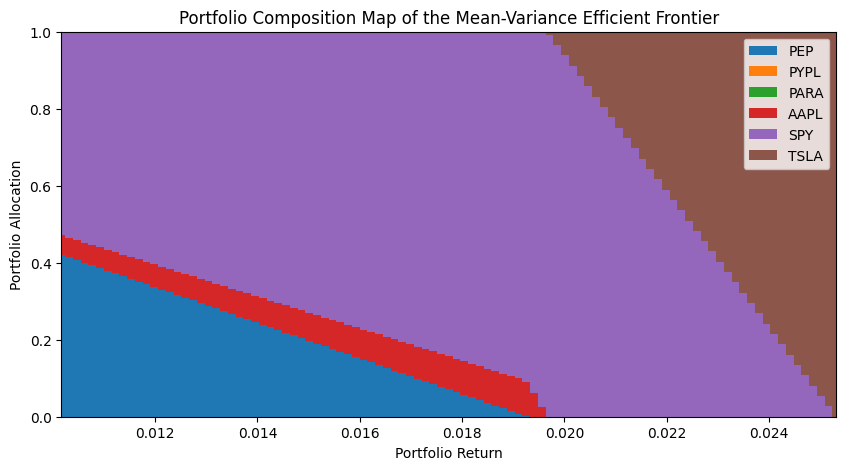

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
bottom = np.zeros(ef_portfolios.shape[0])

# Ensure the plotting order matches the portfolio columns
for i, a in enumerate(assets):
    plt.bar(x=ef_returns,
            height=ef_portfolios[:, i],
            bottom=bottom,
            label=a,
            width=(ef_returns[1] - ef_returns[0]))
    bottom += ef_portfolios[:, i]

plt.legend()
plt.xlabel("Portfolio Return")
plt.xlim(float(ef_returns.min()), float(ef_returns.max()))
plt.ylabel("Portfolio Allocation")
plt.ylim(0, 1)
plt.title("Portfolio Composition Map of the Mean-Variance Efficient Frontier")
plt.show()

Save the portfolios in a TSV file named "efficient_frontier.tsv".
The header row should have columns "index", "return", "risk", and all the asset tickers.
Each data row should have the portfolio index (0-100), the estimated return of the portfolio, the estimated standard deviation (not variance) of the portfolio, and all the asset allocations (which should sum to one).

In [63]:
# YOUR CHANGES HERE

ef_risks = np.sqrt(ef_variances)

# Build DataFrame
ef_df = pd.DataFrame(ef_portfolios, columns=assets)
ef_df.insert(0, "risk", ef_risks)
ef_df.insert(0, "return", ef_returns)
ef_df.insert(0, "index", np.arange(len(ef_returns)))

# Allocations sum to 1 
assert np.allclose(ef_df[assets].sum(axis=1), 1.0, atol=1e-6)

# Save to TSV
ef_df.to_csv("efficient_frontier.tsv", sep="\t", index=False, float_format="%.6f")

Submit "efficient_frontier.tsv" in Gradescope.

## Part 8: Check Maximum Return Portfolio Stability

Check the stability of the maximum return portfolio by resampling the estimated risk/return model.

Repeat 1000 times -
1. Use `np.random.multivariate_normal` to generate 23 return samples using your previously estimated risks and returns.
2. Estimate the return of each asset using that resampled return history.
3. Check which asset had the highest return in those resampled estimates.

This procedure is a reduced and simplified version of the Michaud resampled efficient frontier procedure that takes uncertainty in the risk model into account.

In [64]:
# YOUR CHANGES HERE

# Standardize inputs 
if isinstance(estimated_returns, pd.DataFrame):
    mu_s = estimated_returns.set_index("asset")["return"].astype(float)
else:
    mu_s = pd.Series(estimated_returns, dtype=float)
assets = mu_s.index.tolist()
mu = mu_s.values.astype(float)

Sigma = (
    estimated_covariance
    .reindex(index=assets, columns=assets)
    .astype(float)
).values

Sigma = (Sigma + Sigma.T) / 2.0
eigvals = np.linalg.eigvalsh(Sigma)
min_eig = eigvals.min()
if min_eig < 1e-12:
    # add a small ridge to make it PSD
    Sigma += np.eye(Sigma.shape[0]) * (1e-8 - min_eig)

# Resample
B = 1000       # number of resamples
T = 23         # length of return history to simulate (differences of 24 prices)
rng = np.random.default_rng(704)

winner_counts = np.zeros(len(assets), dtype=int)

for _ in range(B):
    # simulate T monthly returns from MVN(mu, Sigma)
    sim = rng.multivariate_normal(mean=mu, cov=Sigma, size=T)  # shape (T, n_assets)
    sim_means = sim.mean(axis=0)                                # mean return per asset
    winner = int(np.argmax(sim_means))                          # index of top-mean asset
    winner_counts[winner] += 1

winner_share = winner_counts / B

stability_df = pd.DataFrame({
    "asset": assets,
    "wins": winner_counts,
    "share": winner_share
}).sort_values("share", ascending=False).reset_index(drop=True)

print(stability_df)

orig_best = mu_s.idxmax()
orig_best_share = float(stability_df.loc[stability_df["asset"] == orig_best, "share"])
print(f"\nOriginal max-return asset: {orig_best} — wins in {orig_best_share:.3f} of resamples.")


  asset  wins    share
0  TSLA   456 0.456000
1  PARA   191 0.191000
2   SPY   178 0.178000
3  AAPL   113 0.113000
4  PYPL    62 0.062000
5   PEP     0 0.000000

Original max-return asset: TSLA — wins in 0.456 of resamples.


/tmp/ipykernel_56857/1401760613.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  orig_best_share = float(stability_df.loc[stability_df["asset"] == orig_best, "share"])


Save a file "max_return_probabilities.tsv" with the distribution of highest return assets.
The header row should have columns "asset" and "probability".
There should be a data row for each asset and its sample probability of having the highest return based on those 1000 resampled estimates.


In [65]:
# YOUR CHANGES HERE

B = 1000  # number of resamples used

# Build probability DataFrame
prob_df = pd.DataFrame({
    "asset": assets,
    "probability": winner_counts / B
})

# Save to TSV 
prob_df.to_csv("max_return_probabilities.tsv", sep="\t", index=False, float_format="%.6f")

In [66]:
prob_df.head()

,asset,probability
0,PEP,0.000000
1,PYPL,0.062000
2,PARA,0.191000
3,AAPL,0.113000
4,SPY,0.178000


In [67]:
prob_df.shape

(6, 2)

Submit "max_return_probabilities.tsv" in Gradescope.

## Part 9: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


In [68]:
from pathlib import Path

# Create acknowledgements.txt in the current working directory
Path("acknowledgements.txt").write_text("I only used Week 1 lecture code.\n", encoding="utf-8")

# Sanity check
p = Path("acknowledgements.txt").resolve()
print("Wrote:", p)
print("Exists:", p.exists())

Wrote: /workspaces/dx704-project-01/acknowledgements.txt
Exists: True


Submit "acknowledgements.txt" in Gradescope.

## Part 10: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.